In [1]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg  

In [2]:
!ls ../faci/
key_pts_frame = pd.read_csv('../faci/training.csv')
key_pts_frame.keys

IdLookupTable.csv     test.csv	training.csv
SampleSubmission.csv  test.zip	training.zip


<bound method NDFrame.keys of       left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0             66.033564          39.002274           30.227008   
1             64.332936          34.970077           29.949277   
2             65.057053          34.909642           30.903789   
3             65.225739          37.261774           32.023096   
4             66.725301          39.621261           32.244810   
...                 ...                ...                 ...   
7044          67.402546          31.842551           29.746749   
7045          66.134400          38.365501           30.478626   
7046          66.690732          36.845221           31.666420   
7047          70.965082          39.853666           30.543285   
7048          66.938311          43.424510           31.096059   

      right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0              36.421678                59.582075                39.647423   
1              33.448

In [3]:
key_pts_frame.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
left_eye_center_x            7039 non-null float64
left_eye_center_y            7039 non-null float64
right_eye_center_x           7036 non-null float64
right_eye_center_y           7036 non-null float64
left_eye_inner_corner_x      2271 non-null float64
left_eye_inner_corner_y      2271 non-null float64
left_eye_outer_corner_x      2267 non-null float64
left_eye_outer_corner_y      2267 non-null float64
right_eye_inner_corner_x     2268 non-null float64
right_eye_inner_corner_y     2268 non-null float64
right_eye_outer_corner_x     2268 non-null float64
right_eye_outer_corner_y     2268 non-null float64
left_eyebrow_inner_end_x     2270 non-null float64
left_eyebrow_inner_end_y     2270 non-null float64
left_eyebrow_outer_end_x     2225 non-null float64
left_eyebrow_outer_end_y     2225 non-null float64
right_eyebrow_inner_end_x    2270 non-null float64
right_eyebrow_inner_end_y 

/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


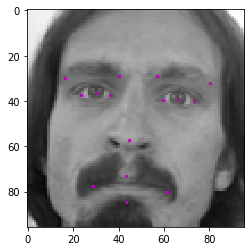

In [4]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image, cmap='gray')
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

n=0
# key_pts_frame.describe()
image = key_pts_frame.iloc[n, -1]
key_pts = key_pts_frame.iloc[n, :-1].as_matrix()
key_pts = key_pts.astype('float').reshape(-1, 2)
image = np.array(image.split(),dtype=np.float).reshape(96,-1)
show_keypoints(image,key_pts)

In [5]:
from torch.utils.data import Dataset, DataLoader
class FacialKeypointsDataset(Dataset):

    def __init__(self, csv_file, transform=None, Train=True):
        self.key_pts_frame = pd.read_csv(csv_file)
        split_len = int(len(self.key_pts_frame)/2)
        if Train:
            self.key_pts_frame= self.key_pts_frame[:split_len]
        else:
            self.key_pts_frame= self.key_pts_frame[split_len:]
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        
        image  = np.array(key_pts_frame.iloc[idx, -1].split(),dtype=np.float).reshape((96,96))
        key_pts = self.key_pts_frame.iloc[idx, :-1].as_matrix()
        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [6]:
import torch
from torchvision import transforms

class Normalize(object):
    def __call__(self, sample):
        image = sample['image']/255.0
        return  {'image':image,
                'keypoints': key_pts}

class ToTensor(object):
    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
        
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

In [7]:
data_transform = transforms.Compose([Normalize(),ToTensor()])

batch_size = 16
train_dataset = FacialKeypointsDataset(csv_file='/home/a/Desktop/faci/training.csv',transform=data_transform)
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4) 

test_dataset = FacialKeypointsDataset(csv_file='/home/a/Desktop/faci/training.csv',transform=data_transform,Train=False)
test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

In [8]:
list(filter(lambda x: x[0]!= '_' ,dir(test_loader))),list(filter(lambda x: x[0] != '_' ,dir(test_dataset)))

(['batch_sampler',
  'batch_size',
  'collate_fn',
  'dataset',
  'dataset_kind',
  'drop_last',
  'multiprocessing_context',
  'num_workers',
  'pin_memory',
  'sampler',
  'timeout',
  'worker_init_fn'],
 ['key_pts_frame', 'transform'])

In [9]:
def net_sample_output():
    net.eval()
    for i, sample in enumerate(test_loader):
        images = sample['image']
        key_pts = sample['keypoints']
        images = images.type(torch.FloatTensor)
        output_pts = net(images)
        output_pts = output_pts.view(output_pts.size()[0], 15, -1)
        if i == 0:
            return images, output_pts, key_pts            

In [10]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        #96-5/1 +1 = 92  -- after maxpool = 32 filters of 1X46X46 = 32X46X46 
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.dropout1 = nn.Dropout(p=0.2)
        
        self.pool = nn.MaxPool2d(2, 2)
    
        #  output size = (W-F)/S +1  = 46-3/1 +1 = 44-->after maxpool = 64X22X22
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.dropout2 = nn.Dropout(p=0.3)
        
        
        self.fc1 = nn.Linear(64*22*22, 22*30)
        self.fc1_drop = nn.Dropout(p=0.4)
        
        
        self.fc2 = nn.Linear(22*30, 30)
        
        
    def forward(self, x):
        x = self.dropout1(self.pool(F.relu(self.conv1(x))))
        x = self.dropout2(self.pool(F.elu(self.conv2(x)))) 
        x = x.view(x.size(0), -1)
        x = F.elu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)
        
        return x

In [19]:
net = Net()
test_images, test_outputs, gt_pts = net_sample_output()

/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [12]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


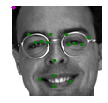

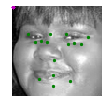

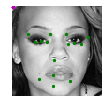

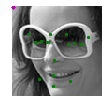

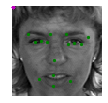

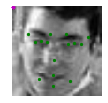

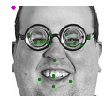

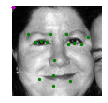

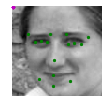

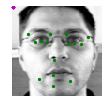

In [13]:
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)
        import pdb
#         pdb.set_trace()
        image = test_images[i].numpy() 
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
 
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
         
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i] 
         
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()

visualize_output(test_images, test_outputs, gt_pts)

In [14]:
import torch.optim as optim
criterion = nn.modules.SmoothL1Loss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

def train_net(n_epochs):

    net.train()
    for epoch in range(n_epochs):  
        running_loss = 0.0

      
        for batch_i, data in enumerate(train_loader):
            images = data['image']
            key_pts = data['keypoints']
            key_pts = key_pts.view(key_pts.size(0), -1)
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            output_pts = net(images)

            loss = criterion(output_pts, key_pts)

            optimizer.zero_grad()
            
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')
from datetime import datetime
n_epochs = 10
start = datetime.now()
train_net(n_epochs)
end = datetime.now()
elapsed_time = end - start
print('Elapse Time:{}\nAverage Time:{}'.format(elapsed_time, elapsed_time/ n_epochs))
 

/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 1, Batch: 10, Avg. Loss: 25.841632747650145
Epoch: 1, Batch: 20, Avg. Loss: 9.259939002990723
Epoch: 1, Batch: 30, Avg. Loss: 6.267225027084351
Epoch: 1, Batch: 40, Avg. Loss: 4.76785638332367
Epoch: 1, Batch: 50, Avg. Loss: 4.0487573623657225
Epoch: 1, Batch: 60, Avg. Loss: 3.5340034484863283
Epoch: 1, Batch: 70, Avg. Loss: 3.056606650352478
Epoch: 1, Batch: 80, Avg. Loss: 3.1614777565002443
Epoch: 1, Batch: 90, Avg. Loss: 3.1537471055984496
Epoch: 1, Batch: 100, Avg. Loss: 2.8625884294509887
Epoch: 1, Batch: 110, Avg. Loss: 2.6124630689620973
Epoch: 1, Batch: 120, Avg. Loss: 2.4476674795150757
Epoch: 1, Batch: 130, Avg. Loss: 2.334509778022766
Epoch: 1, Batch: 140, Avg. Loss: 2.3494471073150636
Epoch: 1, Batch: 150, Avg. Loss: 2.546327590942383
Epoch: 1, Batch: 160, Avg. Loss: 2.2704922795295714
Epoch: 1, Batch: 170, Avg. Loss: 2.022578680515289
Epoch: 1, Batch: 180, Avg. Loss: 2.206714630126953
Epoch: 1, Batch: 190, Avg. Loss: 2.3827237248420716
Epoch: 1, Batch: 200, Avg. Los

/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 2, Batch: 10, Avg. Loss: 1.7693698167800904
Epoch: 2, Batch: 20, Avg. Loss: 2.0364357590675355
Epoch: 2, Batch: 30, Avg. Loss: 1.6670187830924987
Epoch: 2, Batch: 40, Avg. Loss: 1.5098540902137756
Epoch: 2, Batch: 50, Avg. Loss: 1.6268696069717408
Epoch: 2, Batch: 60, Avg. Loss: 1.751181137561798
Epoch: 2, Batch: 70, Avg. Loss: 1.995976459980011
Epoch: 2, Batch: 80, Avg. Loss: 1.9116525530815125
Epoch: 2, Batch: 90, Avg. Loss: 2.2282631039619445
Epoch: 2, Batch: 100, Avg. Loss: 1.659280574321747
Epoch: 2, Batch: 110, Avg. Loss: 1.6296805143356323
Epoch: 2, Batch: 120, Avg. Loss: 1.4972777962684631
Epoch: 2, Batch: 130, Avg. Loss: 1.5995274126529693
Epoch: 2, Batch: 140, Avg. Loss: 1.5855330109596253
Epoch: 2, Batch: 150, Avg. Loss: 1.4642651677131653
Epoch: 2, Batch: 160, Avg. Loss: 1.478517723083496
Epoch: 2, Batch: 170, Avg. Loss: 1.4499951004981995
Epoch: 2, Batch: 180, Avg. Loss: 1.2583177864551545
Epoch: 2, Batch: 190, Avg. Loss: 1.2966315388679504
Epoch: 2, Batch: 200, Avg

/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 3, Batch: 10, Avg. Loss: 1.3780465424060822
Epoch: 3, Batch: 20, Avg. Loss: 1.33929985165596
Epoch: 3, Batch: 30, Avg. Loss: 1.3038051545619964
Epoch: 3, Batch: 40, Avg. Loss: 1.169082921743393
Epoch: 3, Batch: 50, Avg. Loss: 1.563936060667038
Epoch: 3, Batch: 60, Avg. Loss: 1.451677107810974
Epoch: 3, Batch: 70, Avg. Loss: 1.1087624549865722
Epoch: 3, Batch: 80, Avg. Loss: 1.1393601655960084
Epoch: 3, Batch: 90, Avg. Loss: 1.1312166929244996
Epoch: 3, Batch: 100, Avg. Loss: 1.0785786271095277
Epoch: 3, Batch: 110, Avg. Loss: 1.250684279203415
Epoch: 3, Batch: 120, Avg. Loss: 1.2914812564849854
Epoch: 3, Batch: 130, Avg. Loss: 1.179400783777237
Epoch: 3, Batch: 140, Avg. Loss: 1.1273831367492675
Epoch: 3, Batch: 150, Avg. Loss: 1.168059104681015
Epoch: 3, Batch: 160, Avg. Loss: 1.1711805760860443
Epoch: 3, Batch: 170, Avg. Loss: 1.0591445982456207
Epoch: 3, Batch: 180, Avg. Loss: 1.045807272195816
Epoch: 3, Batch: 190, Avg. Loss: 1.1051145136356353
Epoch: 3, Batch: 200, Avg. Los

/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 4, Batch: 10, Avg. Loss: 1.2140458285808564
Epoch: 4, Batch: 20, Avg. Loss: 1.1578127562999725
Epoch: 4, Batch: 30, Avg. Loss: 1.1564676463603973
Epoch: 4, Batch: 40, Avg. Loss: 1.241884708404541
Epoch: 4, Batch: 50, Avg. Loss: 0.9391040980815888
Epoch: 4, Batch: 60, Avg. Loss: 1.0918461203575134
Epoch: 4, Batch: 70, Avg. Loss: 1.1055723130702972
Epoch: 4, Batch: 80, Avg. Loss: 1.0950211375951766
Epoch: 4, Batch: 90, Avg. Loss: 1.0461012423038483
Epoch: 4, Batch: 100, Avg. Loss: 0.9250128149986268
Epoch: 4, Batch: 110, Avg. Loss: 0.9933353424072265
Epoch: 4, Batch: 120, Avg. Loss: 1.1283657550811768
Epoch: 4, Batch: 130, Avg. Loss: 1.0895193576812745
Epoch: 4, Batch: 140, Avg. Loss: 1.1056626439094543
Epoch: 4, Batch: 150, Avg. Loss: 1.107219636440277
Epoch: 4, Batch: 160, Avg. Loss: 1.038127988576889
Epoch: 4, Batch: 170, Avg. Loss: 1.2175062716007232
Epoch: 4, Batch: 180, Avg. Loss: 0.9934578955173492
Epoch: 4, Batch: 190, Avg. Loss: 0.8954454720020294
Epoch: 4, Batch: 200, Av

/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 5, Batch: 10, Avg. Loss: 1.088693195581436
Epoch: 5, Batch: 20, Avg. Loss: 1.1473640620708465
Epoch: 5, Batch: 30, Avg. Loss: 1.104913103580475
Epoch: 5, Batch: 40, Avg. Loss: 0.9311374604701996
Epoch: 5, Batch: 50, Avg. Loss: 1.1509098649024962
Epoch: 5, Batch: 60, Avg. Loss: 1.0535528182983398
Epoch: 5, Batch: 70, Avg. Loss: 1.4632328271865844
Epoch: 5, Batch: 80, Avg. Loss: 1.041268789768219
Epoch: 5, Batch: 90, Avg. Loss: 1.1043712496757507
Epoch: 5, Batch: 100, Avg. Loss: 1.0797223210334779
Epoch: 5, Batch: 110, Avg. Loss: 1.2925531804561614
Epoch: 5, Batch: 120, Avg. Loss: 0.8625731706619263
Epoch: 5, Batch: 130, Avg. Loss: 0.9345556020736694
Epoch: 5, Batch: 140, Avg. Loss: 0.8703372836112976
Epoch: 5, Batch: 150, Avg. Loss: 1.0092314720153808
Epoch: 5, Batch: 160, Avg. Loss: 1.0166589856147765
Epoch: 5, Batch: 170, Avg. Loss: 1.0368828058242798
Epoch: 5, Batch: 180, Avg. Loss: 0.9010074675083161
Epoch: 5, Batch: 190, Avg. Loss: 0.8318654924631119
Epoch: 5, Batch: 200, Av

/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 6, Batch: 10, Avg. Loss: 1.0956902623176574
Epoch: 6, Batch: 20, Avg. Loss: 1.124891996383667
Epoch: 6, Batch: 30, Avg. Loss: 0.9112162530422211
Epoch: 6, Batch: 40, Avg. Loss: 1.0890471577644347
Epoch: 6, Batch: 50, Avg. Loss: 1.0454851508140564
Epoch: 6, Batch: 60, Avg. Loss: 1.0725528299808502
Epoch: 6, Batch: 70, Avg. Loss: 0.9133090496063232
Epoch: 6, Batch: 80, Avg. Loss: 0.9464707493782043
Epoch: 6, Batch: 90, Avg. Loss: 1.2671955049037933
Epoch: 6, Batch: 100, Avg. Loss: 0.8855577528476715
Epoch: 6, Batch: 110, Avg. Loss: 0.9095385432243347
Epoch: 6, Batch: 120, Avg. Loss: 0.9508184790611267
Epoch: 6, Batch: 130, Avg. Loss: 0.9359560489654541
Epoch: 6, Batch: 140, Avg. Loss: 1.017417997121811
Epoch: 6, Batch: 150, Avg. Loss: 1.0355536878108977
Epoch: 6, Batch: 160, Avg. Loss: 0.9711118340492249
Epoch: 6, Batch: 170, Avg. Loss: 1.0233656466007233
Epoch: 6, Batch: 180, Avg. Loss: 1.0670747935771943
Epoch: 6, Batch: 190, Avg. Loss: 1.186775267124176
Epoch: 6, Batch: 200, Av

/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 7, Batch: 10, Avg. Loss: 1.0144897162914277
Epoch: 7, Batch: 20, Avg. Loss: 1.0412342965602874
Epoch: 7, Batch: 30, Avg. Loss: 0.9727123379707336
Epoch: 7, Batch: 40, Avg. Loss: 1.1575273096561431
Epoch: 7, Batch: 50, Avg. Loss: 1.1462972342967988
Epoch: 7, Batch: 60, Avg. Loss: 1.135871559381485
Epoch: 7, Batch: 70, Avg. Loss: 0.871490940451622
Epoch: 7, Batch: 80, Avg. Loss: 1.2038625538349152
Epoch: 7, Batch: 90, Avg. Loss: 0.9877773880958557
Epoch: 7, Batch: 100, Avg. Loss: 0.8722257733345031
Epoch: 7, Batch: 110, Avg. Loss: 1.0468511760234833
Epoch: 7, Batch: 120, Avg. Loss: 0.9056231796741485
Epoch: 7, Batch: 130, Avg. Loss: 0.8143129229545594
Epoch: 7, Batch: 140, Avg. Loss: 0.9437394857406616
Epoch: 7, Batch: 150, Avg. Loss: 0.8002712607383728
Epoch: 7, Batch: 160, Avg. Loss: 1.0219984114170075
Epoch: 7, Batch: 170, Avg. Loss: 0.8683205068111419
Epoch: 7, Batch: 180, Avg. Loss: 0.9613539576530457
Epoch: 7, Batch: 190, Avg. Loss: 1.0081016302108765
Epoch: 7, Batch: 200, A

/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 8, Batch: 10, Avg. Loss: 0.9012905895709992
Epoch: 8, Batch: 20, Avg. Loss: 0.9050852298736572
Epoch: 8, Batch: 30, Avg. Loss: 0.9725280344486237
Epoch: 8, Batch: 40, Avg. Loss: 1.1067223966121673
Epoch: 8, Batch: 50, Avg. Loss: 0.9611712515354156
Epoch: 8, Batch: 60, Avg. Loss: 0.8678759098052978
Epoch: 8, Batch: 70, Avg. Loss: 0.9368038773536682
Epoch: 8, Batch: 80, Avg. Loss: 0.9088420391082763
Epoch: 8, Batch: 90, Avg. Loss: 1.0609136819839478
Epoch: 8, Batch: 100, Avg. Loss: 0.9094234436750412
Epoch: 8, Batch: 110, Avg. Loss: 0.9069518029689789
Epoch: 8, Batch: 120, Avg. Loss: 0.9697878003120423
Epoch: 8, Batch: 130, Avg. Loss: 0.7715756177902222
Epoch: 8, Batch: 140, Avg. Loss: 1.070906674861908
Epoch: 8, Batch: 150, Avg. Loss: 1.1249197602272034
Epoch: 8, Batch: 160, Avg. Loss: 0.8826546132564544
Epoch: 8, Batch: 170, Avg. Loss: 1.0636859595775605
Epoch: 8, Batch: 180, Avg. Loss: 0.9674438595771789
Epoch: 8, Batch: 190, Avg. Loss: 0.9281198501586914
Epoch: 8, Batch: 200, 

/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 9, Batch: 10, Avg. Loss: 0.8805145978927612
Epoch: 9, Batch: 20, Avg. Loss: 0.9790479838848114
Epoch: 9, Batch: 30, Avg. Loss: 0.9352830290794373
Epoch: 9, Batch: 40, Avg. Loss: 0.9254030108451843
Epoch: 9, Batch: 50, Avg. Loss: 0.9991581737995148
Epoch: 9, Batch: 60, Avg. Loss: 0.7858536720275879
Epoch: 9, Batch: 70, Avg. Loss: 0.8188515484333039
Epoch: 9, Batch: 80, Avg. Loss: 0.8874626100063324
Epoch: 9, Batch: 90, Avg. Loss: 0.954734492301941
Epoch: 9, Batch: 100, Avg. Loss: 0.835520225763321
Epoch: 9, Batch: 110, Avg. Loss: 0.9939738214015961
Epoch: 9, Batch: 120, Avg. Loss: 0.9868709206581116
Epoch: 9, Batch: 130, Avg. Loss: 1.0928068995475768
Epoch: 9, Batch: 140, Avg. Loss: 0.8484396517276764
Epoch: 9, Batch: 150, Avg. Loss: 0.9110929667949677
Epoch: 9, Batch: 160, Avg. Loss: 0.9978355228900909
Epoch: 9, Batch: 170, Avg. Loss: 0.988321167230606
Epoch: 9, Batch: 180, Avg. Loss: 0.9750359177589416
Epoch: 9, Batch: 190, Avg. Loss: 1.0384138703346253
Epoch: 9, Batch: 200, Av

/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 10, Batch: 10, Avg. Loss: 0.8773202776908875
Epoch: 10, Batch: 20, Avg. Loss: 0.9614590704441071
Epoch: 10, Batch: 30, Avg. Loss: 1.032689917087555
Epoch: 10, Batch: 40, Avg. Loss: 0.8051846951246262
Epoch: 10, Batch: 50, Avg. Loss: 1.1205652177333831
Epoch: 10, Batch: 60, Avg. Loss: 0.9483713805675507
Epoch: 10, Batch: 70, Avg. Loss: 0.9445254325866699
Epoch: 10, Batch: 80, Avg. Loss: 0.952406930923462
Epoch: 10, Batch: 90, Avg. Loss: 0.9944840013980866
Epoch: 10, Batch: 100, Avg. Loss: 1.1689091563224792
Epoch: 10, Batch: 110, Avg. Loss: 1.1897859752178193
Epoch: 10, Batch: 120, Avg. Loss: 1.3997111976146699
Epoch: 10, Batch: 130, Avg. Loss: 1.084759032726288
Epoch: 10, Batch: 140, Avg. Loss: 1.073712831735611
Epoch: 10, Batch: 150, Avg. Loss: 1.0389069110155105
Epoch: 10, Batch: 160, Avg. Loss: 0.8949681341648101
Epoch: 10, Batch: 170, Avg. Loss: 0.8480258047580719
Epoch: 10, Batch: 180, Avg. Loss: 0.897317773103714
Epoch: 10, Batch: 190, Avg. Loss: 0.8764157176017762
Epoch: 

/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/a/.virtualenvs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


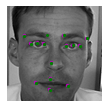

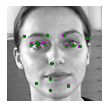

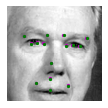

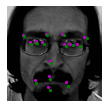

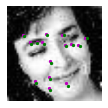

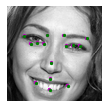

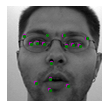

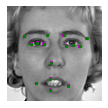

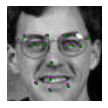

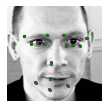

In [18]:
test_images, test_outputs, gt_pts = net_sample_output() 
visualize_output(test_images, test_outputs, gt_pts)

In [17]:
model_dir = 'saved_models/'
model_name = 'keypoints_detection.pt'
torch.save(net.state_dict(), model_dir+model_name)